In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
import pyaudio;
import wave;
import scipy.io.wavfile as sciiowav;
import scipy.signal as scisig;

%matplotlib notebook

In [2]:
A4   = 440.0; #Hz
RATE = 44100.0; #Hz 
VOL = 0.25;

#para el temperamento igual
def num2freq(n):
    return A4*np.power(2.0,(n-69.0)/12.0);

#onda sinusoidal
def get_sine(n,s,h=1):
    s_ = np.arange(int(RATE*s));
    return np.sin(2.0*np.pi*h*(num2freq(n)/RATE)*s_);

#
def get_sawtooth(n,s):
    s_ = np.arange(int(RATE*s));
    return scisig.sawtooth(2.0*np.pi*(num2freq(n)/RATE)*s_);

def get_triangle(n,s):
    s_ = np.arange(int(RATE*s));
    return 2.0*np.abs(scisig.sawtooth(2.0*np.pi*(num2freq(n)/RATE)*s_))-1.0;

def get_square(n,s):
    s_ = np.arange(int(RATE*s));
    return scisig.square(2.0*np.pi*(num2freq(n)/RATE)*s_);

def play(sound):
    
    #abrir puerto para sonido
    p = pyaudio.PyAudio();
    puerto = p.open(format=pyaudio.paFloat32,channels=1,rate=44100,output=True);
    
    #mandar el sonido al puerto
    puerto.write(sound.astype(np.float32).tobytes());
    #debe mandarse en forma de bytes, por ende, se usa .tobytes()
    puerto.stop_stream();
    
    #cerrar el puerto
    puerto.close();

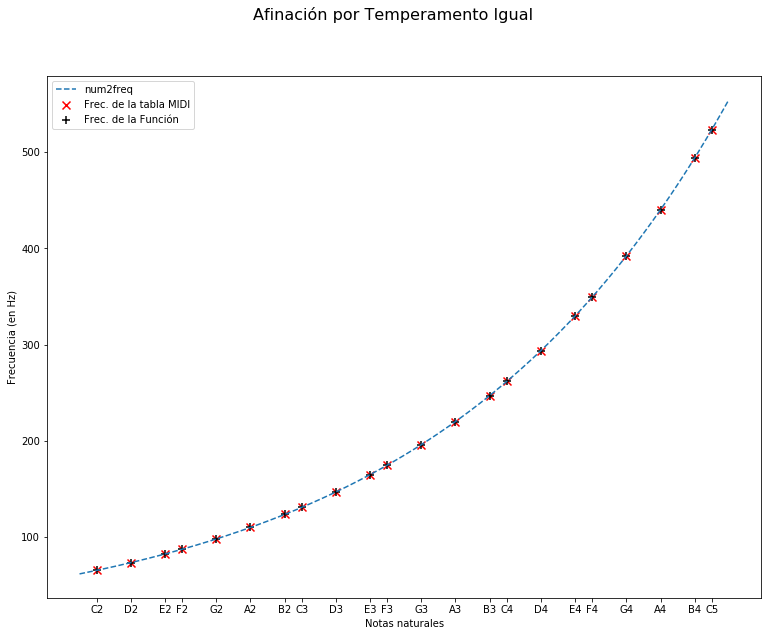

In [3]:
#Tabla de afinación para el sistema MIDI, lo copié directamente de Wikipedia: 
#https://en.wikipedia.org/wiki/Scientific_pitch_notation

note_fs = np.array([ 65.406, 69.296, 73.416, 77.782, 82.407, 87.307, 92.499, 97.999,103.830,110.000,116.540,123.470,
                    130.810,138.590,146.830,155.560,164.810,174.610,185.000,196.000,207.650,220.000,233.080,246.940, 
                    261.630,277.180,293.660,311.130,329.630,349.230,369.990,392.000,415.300,440.000,466.160,493.880,
                    523.250
                   ]);


note_n  = np.array([36 , 38 , 40 , 41 , 43 , 45 , 47 , 48 , 50 , 52 , 53 , 55 , 57 , 59 , 60 , 62 , 64 , 65 , 67 , 69 , 71 , 72 ]);
note_c = np.array(['C2','D2','E2','F2','G2','A2','B2','C3','D3','E3','F3','G3','A3','B3','C4','D4','E4','F4','G4','A4','B4','C5']);


fig,ax = plt.subplots(1,1,figsize=(12.8,9.6));

fig.suptitle(u'Afinación por Temperamento Igual', fontsize=16);

ax.set_xlabel('Notas naturales');
ax.set_ylabel('Frecuencia (en Hz)');

ax.set_xticks(note_n);
ax.set_xticklabels(note_c);

ax.scatter(note_n,note_fs[note_n-36],s=64,c='r',marker='x'),ax.scatter(note_n,num2freq(note_n),s=64,c='k',marker='+'),
ax.plot(np.linspace(35.0,73.0,1000),num2freq(np.linspace(35.0,73.0,1000)),'--');

ax.legend(['num2freq','Frec. de la tabla MIDI',u'Frec. de la Función',])

C0 ~ 16.3515978313 Hz


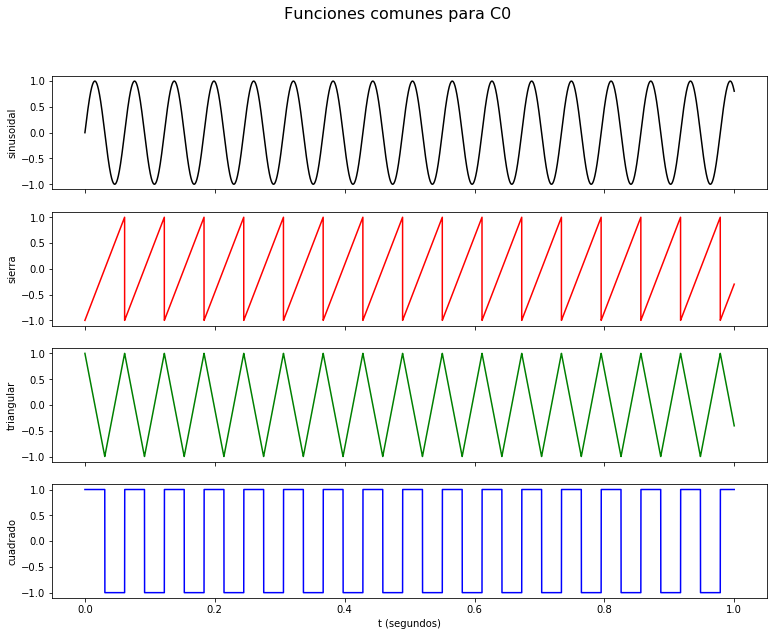

In [4]:
t = np.arange(int(RATE))/RATE;

print "C0 ~ "+ str(num2freq(12)) + " Hz"; 
#Nosotros ya no podemos escucharlo... es infrasónico.
#Y es díficil que la máquina lo reproduzca.

fig,ax = plt.subplots(4,1,figsize=(12.8,9.6),sharex=True);
fig.suptitle('Funciones comunes para C0', fontsize=16);


ax[0].set_ylabel('sinusoidal');
ax[0].plot(t,get_sine(12,1.0),c='k');
ax[1].set_ylabel('sierra');
ax[1].plot(t,get_sawtooth(12,1.0),c='r');
ax[2].set_ylabel('triangular');
ax[2].plot(t,get_triangle(12,1.0),c='g');
ax[3].set_ylabel('cuadrado');
ax[3].set_xlabel('t (segundos)');
ax[3].plot(t,get_square(12,1.0),c='b');

In [5]:
#Exploración de timbres distintos.
A4_sine = get_sine(69,1);
play(VOL*A4_sine);

A4_tri = get_triangle(69,1);
play(VOL*A4_tri);

A4_saw = get_sawtooth(69,1);
play(VOL*A4_saw);

A4_squ = get_square(69,1);
play(VOL*A4_squ);

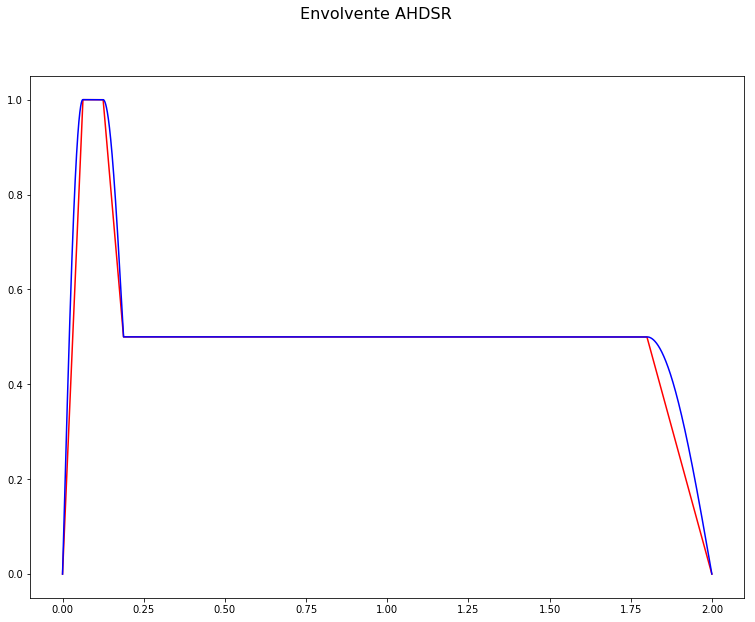

In [6]:
def get_custom(get_f,get_up,get_low):
    return lambda n,s: (0.5*(get_f(n,s)+1.0))*(get_up(s)-get_low(s))+get_low(s);

def ahdsr_recta(s):
    s_ = np.arange(int(RATE*s))/RATE;
    return (16.0*s_)*(16.0*s_<1.0)+1.0*(1.0 <= 16.0*s_)*(16.0*s_<2.0)+(2.0-8.0*s_)*(2.0 <= 16.0*s_)*(16.0*s_ < 3.0)+0.5*(3.0 <= 16.0*s_)*(s_ < 0.9*s) + 0.5*(0.9*s <= s_)*(10.*s-10.0*s_)/s;

def ahdsr_smooth(s):
    s_ = np.arange(int(RATE*s))/RATE;
    return np.sin(8.0*np.pi*s_)*(16.0*s_<1.0)+1.0*(1.0 <= 16.0*s_)*(16.0*s_<2.0)+(0.5+0.5*np.cos(8.0*np.pi*(s_-2.0/16.0)))*(2.0 <= 16.0*s_)*(16.0*s_ < 3.0)+0.5*(3.0 <= 16.0*s_)*(s_ < 0.9*s) + 0.5*(0.9*s <= s_)*np.cos(0.5*np.pi*(10.*s_-9*s)/s);

fig,ax = plt.subplots(1,1,figsize=(12.8,9.6),sharex=True);

fig.suptitle(u'Envolvente AHDSR', fontsize=16);
ax.plot(np.linspace(0.0,2.0,int(2*RATE)),ahdsr_recta(2.0),'r'),ax.plot(np.linspace(0.0,2.0,int(2*RATE)),ahdsr_smooth(2.0),'b');


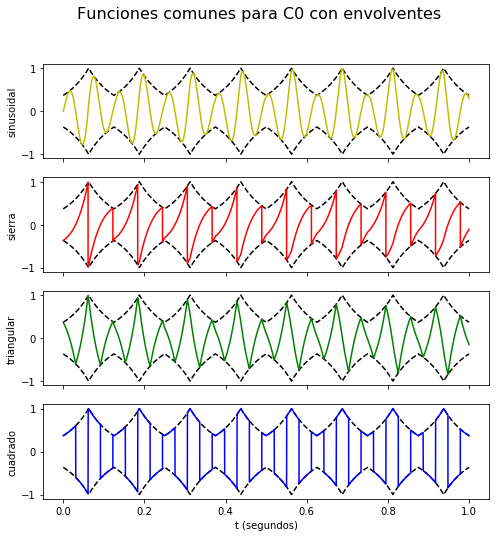

In [7]:
#Exploración de envolventes.

def up(s):
    s_ = np.arange(int(RATE*s))/(s*RATE);
    #return ahdsr_recta(s);
    #return ahdsr_smooth(s);
    return np.exp(-2.0*np.abs(np.mod(8.0*s_,1.0)-0.5));
    #return np.exp(-2.5*s_);
    #return np.exp(-5.0*s_)+(s_ > 0.01)*np.exp(-4.0*(s_-0.01));
    #return np.abs(np.sin(2.0*np.pi*s_)*np.sin(9.0*np.pi*s_));
    #return np.zeros((int(RATE*s),));
    #return np.ones((int(RATE*s),));

def low(s):
    s_ = np.arange(int(RATE*s))/(s*RATE);
    #return -ahdsr(s);
    #return -ahdsr_smooth(s);
    return -np.exp(-2.0*np.abs(np.mod(8.0*s_,1.0)-0.5));
    #return -np.exp(-2.5*s_);
    #return -np.exp(-5.0*s_)-(s_ > 0.01)*np.exp(-4.0*(s_-0.01));
    #return -np.abs(np.sin(2.0*np.pi*s_)*np.sin(9.0*np.pi*s_));
    #return np.zeros((int(RATE*s),));
    #return -np.ones((int(RATE*s),));
fig,ax = plt.subplots(4,1,figsize=(8.0,8.0),sharex=True);
fig.suptitle('Funciones comunes para C0 con envolventes', fontsize=16);


cus_sin = get_custom(get_sine,up,low);
cus_saw = get_custom(get_sawtooth,up,low);
cus_tri = get_custom(get_triangle,up,low);
cus_squ = get_custom(get_square,up,low);

up_1 = up(1.0);
low_1 = low(1.0);
ax[0].set_ylabel('sinusoidal');
ax[0].plot(t,up_1,'k--'),ax[0].plot(t,low_1,'k--'),ax[0].plot(t,cus_sin(12,1.0),c='y');
ax[1].set_ylabel('sierra');
ax[1].plot(t,up_1,'k--'),ax[1].plot(t,low_1,'k--'),ax[1].plot(t,cus_saw(12,1.0),c='r');
ax[2].set_ylabel('triangular');
ax[2].plot(t,up_1,'k--'),ax[2].plot(t,low_1,'k--'),ax[2].plot(t,cus_tri(12,1.0),c='g');
ax[3].set_ylabel('cuadrado');
ax[3].plot(t,up_1,'k--'),ax[3].plot(t,low_1,'k--'),ax[3].plot(t,cus_squ(12,1.0),c='b');
ax[3].set_xlabel('t (segundos)');

In [8]:
cus_sin = get_custom(get_sine,up,low);
cus_saw = get_custom(get_sawtooth,up,low);
cus_tri = get_custom(get_triangle,up,low);
cus_squ = get_custom(get_square,up,low);

#Exploración de timbres distintos.
A4_sin = cus_sin(69,1);
play(VOL*A4_sin);

A4_tri = cus_tri(69,1);
play(VOL*A4_tri);

A4_saw = cus_saw(69,1);
play(VOL*A4_saw);

A4_squ = cus_squ(69,1);
play(VOL*A4_squ);

In [9]:
#Exploración de modos.

modos = {};
modos[u'lidia']     = [[ 0, 2, 4, 6, 7, 9,11,12],[ 0, 4, 7]];
modos[u'jónica']    = [[ 0, 2, 4, 5, 7, 9,11,12],[ 0, 4, 7]];
modos[u'mixolidia'] = [[ 0, 2, 4, 5, 7, 9,10,12],[ 0, 4, 7]];
modos[u'doria' ]    = [[ 0, 2, 3, 5, 7, 9,10,12],[ 0, 3, 7]];
modos[u'éolica']    = [[ 0, 2, 3, 5, 7, 8,10,12],[ 0, 3, 7]];
modos[u'frigia']    = [[ 0, 1, 3, 5, 7, 8,10,12],[ 0, 3, 7]];
modos[u'locria']    = [[ 0, 1, 3, 5, 6, 8,10,12],[ 0, 3, 6]];

#Acomodado por su brillo
nmodos = [u'lidia',
          u'jónica',
          u'mixolidia',
          u'doria' ,
          u'éolica',
          u'frigia',
          u'locria'];

def get_sound(nom,o,get_f):
    scala,prin = modos[nom];
    sonido = np.zeros((0,));
    for n in scala:
        sonido = np.r_[sonido,get_f(n+12*o,0.5)];
    p = get_f(prin[0]+12*o,2.0);
    for i in prin[1:]:
        p += get_f(i+12*o,2.0);
    sonido = np.r_[sonido,p];
    p += get_f(scala[-2]+12*o,2.0);
    sonido = np.r_[sonido,p];
    return sonido;

In [15]:
idx = 4;
print nmodos[idx];
sonido = get_sound(nmodos[idx],3,cus_saw);
play(VOL*sonido);

éolica
